# 03_llama3_qlora_finetune

In this notebook we:
1. Setup the conda env appropriately
2. Explore model training 

In [5]:
# Imports
import torch
import os
import json

import pandas as pd
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datasets import load_dataset
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training

In [2]:
# Check GPU & CUDA
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

PyTorch version: 2.7.0+cu126
CUDA available: True
Device: NVIDIA GeForce GTX 1660 Ti


In [7]:
MODEL_NAME = "meta-llama/Meta-Llama-3.1-8B-Instruct"
DATA_PATH = "../datasets/mi_training_data.jsonl"
OUTPUT_DIR = "../checkpoints/mi_lora_llama3"
MAX_LENGTH = 512

# Load dataset
dataset = load_dataset("json", data_files=DATA_PATH)
dataset = dataset["train"]

# Format dataset
def format_dataset(example):
    return {
        "text": f"<s>[INST] {example['prompt']} [/INST] {example['response']} </s>"
    }

dataset = dataset.map(format_dataset)

dataset = dataset.train_test_split(test_size=0.1, seed=42)

df_sample = pd.DataFrame(dataset["train"][:10])  # Show first 10 formatted training samples

print(dataset["train"][0]["text"])


<s>[INST] Themes: self-compassion, perspective_taking [/INST] What would shift if you offered yourself even a fraction of the care you offer others? </s>


In [8]:
for i in range(3):
    print(dataset["train"][i]["text"])
    print("-" * 80)


<s>[INST] Themes: self-compassion, perspective_taking [/INST] What would shift if you offered yourself even a fraction of the care you offer others? </s>
--------------------------------------------------------------------------------
<s>[INST] Themes: self-compassion, coping_strategies [/INST] What’s one thing you could do today that’s kind and grounding, even for five minutes? </s>
--------------------------------------------------------------------------------
<s>[INST] Themes: support_needs, help-seeking [/INST] What kind of support would actually feel helpful to you right now? </s>
--------------------------------------------------------------------------------


tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

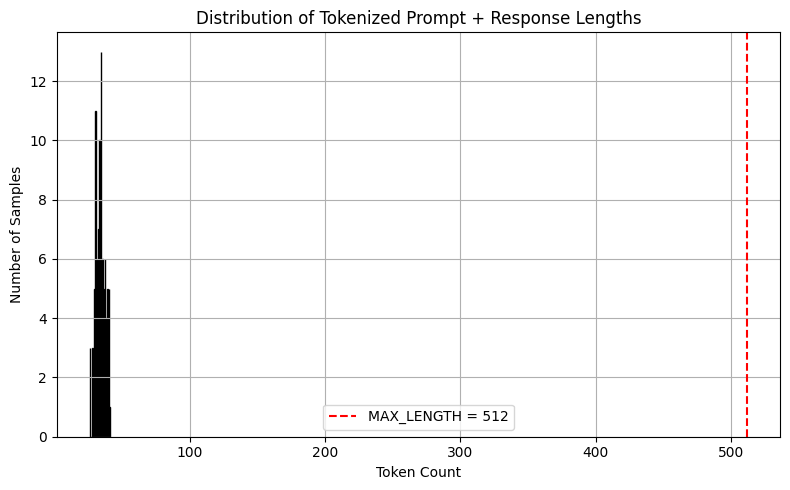

In [9]:
import matplotlib.pyplot as plt

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# Compute token lengths
token_lengths = [
    len(tokenizer(example["text"])["input_ids"])
    for example in dataset["train"]
]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(token_lengths, bins=30, color="skyblue", edgecolor="black")
plt.axvline(MAX_LENGTH, color="red", linestyle="--", label=f"MAX_LENGTH = {MAX_LENGTH}")
plt.xlabel("Token Count")
plt.ylabel("Number of Samples")
plt.title("Distribution of Tokenized Prompt + Response Lengths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
        return_tensors="pt"
    )

# Apply to both train and eval splits
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])


Map:   0%|          | 0/90 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [11]:
tokenized_dataset["train"][0].keys()  # should show 'input_ids', 'attention_mask'


dict_keys(['prompt', 'response', 'input_ids', 'attention_mask'])

In [12]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=3,
    learning_rate=2e-4,
    fp16=True,
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=2,
    report_to="huggingface",        # <--- THIS enables HF logging
    push_to_hub=True,               # Automatically push checkpoints
    hub_model_id="HemanB/interosight-llama3-mi",
    hub_strategy="checkpoint",      # Push every checkpoint
    hub_token=os.getenv("HF_TOKEN") # optional, or use auto login
)


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'